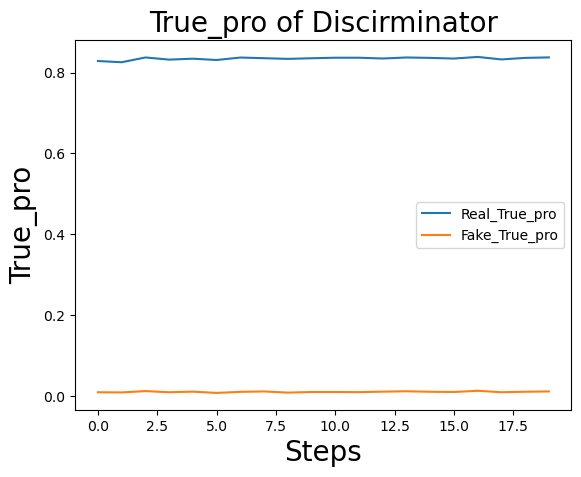

In [3]:
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore as ms
import numpy as np
import mindspore.context as context
from mindspore import Tensor, ops
from mindspore.nn import Adam, LossBase, TrainOneStepCell

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU") # 训练模式 和 上下文管理器
ms.set_seed(1) # 随机数种子
np.random.seed(1)

def get_real_paras(qubit_num=2, sample_num=6):
    real_paras = []
    value_len = 2 ** qubit_num
    for i in range(sample_num):
        data = np.loadtxt('./src/realdata'+str(i)+'.txt')
        sampled_data = data[:,1:4] # omit the timestamp
        sampled_data = sampled_data.reshape(len(sampled_data)*3)
        real_value = sampled_data[0:min(value_len, len(sampled_data))]
        _, parameterResolver = amplitude_encoder(real_value, qubit_num)
        real_paras.append(parameterResolver.params_value)

    return real_paras

def get_fake_paras(qubit_num=2, sample_num=6):
    fake_paras = []
    value_len = 2 ** qubit_num
    values =  np.random.randn(sample_num, value_len)
    for fake_value in values:
        _, parameterResolver = amplitude_encoder(fake_value, qubit_num)
        fake_paras.append(parameterResolver.params_value)
    return fake_paras

def Generator(qubit_num=2):
    circ_, _ =  amplitude_encoder(np.ones(2 ** qubit_num), qubit_num)
    return circ_

def QLayer(qubit_num=2, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += U3(f'{qubit}_0', f'{qubit}_1', f'{qubit}_2').on(qubit)
    for qubit in range(qubit_num-1):
        circ_ += X.on(qubit+1, qubit)
    circ_ += X.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

def Discriminator(qubit_num=2, layer_num=4):
    circ_ = Circuit()
    for _ in range(layer_num):
        circ_ += QLayer(qubit_num=qubit_num, prefix=f'{_}')
    return circ_

def build_grad_ops(qubit_num=2, layer_num=4):
    encoder = Generator(qubit_num)
    encoder.no_grad()
    ansatz = Discriminator(qubit_num, layer_num)
    circ = encoder.as_encoder() + ansatz.as_ansatz()
    sim = Simulator('mqvector', qubit_num)
    ham = Hamiltonian(QubitOperator('Z0'))
    grad_ops = sim.get_expectation_with_grad(ham, circ)
    return grad_ops

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, logits, label):
        out =self.abs(logits - label)
        return self.get_loss(out)

class MyWithLossCell(ms.nn.Cell):
    def __init__(self, backbone, loss_fn):
        super(MyWithLossCell, self).__init__(auto_prefix=False)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, x, label):
        out = self._backbone(x)
        return self._loss_fn(out, label)

    @property
    def backbone_network(self):
        return self._backbone

qubit_num = 2
sample_num = 6
layer_num = 10
real_paras = get_real_paras(qubit_num=qubit_num, sample_num=sample_num)
fake_paras = get_fake_paras(qubit_num=qubit_num, sample_num=sample_num)

QuantumNet = MQLayer(build_grad_ops(qubit_num=qubit_num, layer_num=layer_num))
loss = MyLoss()
net_with_criterion = MyWithLossCell(QuantumNet, loss)
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
net = TrainOneStepCell(net_with_criterion, opti)

epochs = 20
real_pros = []
fake_pros = []

for _ in range(epochs):
    real_pro = []
    fake_pro = []
    for i in range(sample_num):
        real_loss = net(Tensor([real_paras[i]]), Tensor([1.]))
        fake_loss = net(Tensor([fake_paras[2]]), Tensor([-1.]))
        real_pro.append ((QuantumNet(Tensor([real_paras[i]]))[0,0].asnumpy()+1)/2)
        fake_pro.append ((QuantumNet(Tensor([fake_paras[2]]))[0,0].asnumpy()+1)/2)
    real_pros.append(np.mean(real_pro))
    fake_pros.append(np.mean(fake_pro))

plt.figure()
plt.plot(real_pros, label='Real_True_pro', linestyle='-') # 画出训练过程中，验证集分类准确度的变化情况
plt.plot(fake_pros, label='Fake_True_pro', linestyle='-')
plt.title('True_pro of Discirminator', fontsize=20)
plt.legend()
plt.xlabel('Steps', fontsize=20)
plt.ylabel('True_pro', fontsize=20)
plt.savefig('./src/2_qubit_Discriminator.png')
plt.show()

np.save(f'./src/{qubit_num}_qubit_Discriminator_paras.npy', QuantumNet.weight.asnumpy())

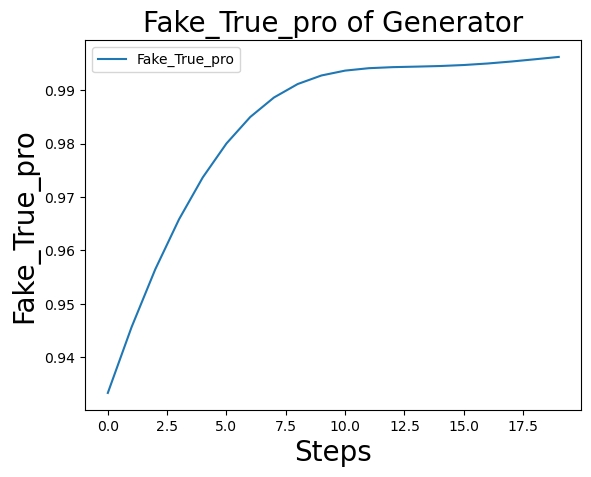

In [5]:
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore as ms
import numpy as np
import mindspore.context as context
from mindspore import Tensor, ops
from mindspore.nn import Adam, LossBase, TrainOneStepCell

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU") # 训练模式 和 上下文管理器
ms.set_seed(1) # 随机数种子
np.random.seed(1)

def Generator(qubit_num=2):
    circ_, _ =  amplitude_encoder(np.ones(2 ** qubit_num), qubit_num)
    return circ_

def QLayer(qubit_num=2, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += U3(f'{qubit}_0', f'{qubit}_1', f'{qubit}_2').on(qubit)
    for qubit in range(qubit_num-1):
        circ_ += X.on(qubit+1, qubit)
    circ_ += X.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

def Discriminator(qubit_num=2, layer_num=4):
    circ_ = Circuit()
    for _ in range(layer_num):
        circ_ += QLayer(qubit_num=qubit_num, prefix=f'{_}')
    return circ_

def build_grad_ops(qubit_num=2, layer_num=4):
    encoder = Generator(qubit_num)
    ansatz = Discriminator(qubit_num, layer_num)
    ansatz.no_grad()
    circ = encoder.as_ansatz() + ansatz.as_encoder()
    sim = Simulator('mqvector', qubit_num)
    ham = Hamiltonian(QubitOperator('Z0'))
    grad_ops = sim.get_expectation_with_grad(ham, circ)
    return grad_ops

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, logits, label):
        out =self.abs(logits - label)
        return self.get_loss(out)

class MyWithLossCell(ms.nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self, x, label):
       out = self._backbone(x)
       return self._loss_fn(out, label)

   @property
   def backbone_network(self):
       return self._backbone

qubit_num = 2
layer_num = 10
discriminator_paras = np.load(f'./src/{qubit_num}_qubit_Discriminator_paras.npy', allow_pickle=True)

QuantumNet = MQLayer(build_grad_ops(qubit_num=qubit_num, layer_num=layer_num))
loss = MyLoss()
net_with_criterion = MyWithLossCell(QuantumNet, loss)
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
net = TrainOneStepCell(net_with_criterion, opti)

steps = 20
fake_pros = []

for _ in range(steps):
    fake_loss = net(Tensor([discriminator_paras]), Tensor([1.]))
    fake_pros.append((QuantumNet(Tensor([discriminator_paras]))[0,0].asnumpy()+1)/2)

plt.figure()
plt.plot(fake_pros, label='Fake_True_pro', linestyle='-')
plt.title('Fake_True_pro of Generator', fontsize=20)
plt.legend()
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Fake_True_pro', fontsize=20)
plt.savefig('./src/2_qubi_Generatort.png')
plt.show()

In [6]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'mindspore')

Software,Version
mindquantum,0.9.0
mindspore,2.1.0
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Tue Oct 17 20:44:29 2023
